In [65]:
# imports
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle

# graphing imports
import chart_studio
from chart_studio.plotly import plot, iplot
import plotly as py
import plotly.tools as tls
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Exploration

In [2]:
# load in dataset
df = pd.read_csv('MLB-Stats.csv')
print(df.shape)
df.head()

(28293, 28)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,RBI,SB,BB,SO,salary,IBB,HBP,SH,SF,PA
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0,0,0,300000,0,0,0,0,0
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0,0,0,387500,0,0,0,0,0
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,0,0,1,403250,0,0,0,0,1
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0,0,0,419000,0,0,0,0,0
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0,0,0,500000,0,0,0,0,0


In [3]:
# df = df[df['Season'] == 1985]
# df.head()

In [4]:
# check for any missing data
df.isnull().sum()

playerID       0
Player Name    0
weight         0
height         0
bats           0
throws         0
Season         0
League         0
teamID         0
Team           0
Franchise      0
G              0
AB             0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
BB             0
SO             0
salary         0
IBB            0
HBP            0
SH             0
SF             0
PA             0
dtype: int64

In [5]:
# interesting stat ideas
# avg salary by year - shows growth in cap, inflation
# total salary per team by year
# how has this changed since moneyball, statistics used to determine best value players?

In [6]:
# change column names from abbreviations to full names to help with domain knowledge
df = df.rename(columns={'G': 'Games_Played', 'AB': 'At_bats', 'R': 'Runs', 'H': 'Hits',
                   '2B': 'Doubles', '3B': 'Triples', 'HR': 'Home_Runs', 'SB': 'Stolen_Base',
                   'BB': 'Walk', 'SO': 'Strikeouts', 'IBB': 'Intentional_Walk', 'HBP': 'Hit_By_Pitch',
                   'SH': 'Sacrifice_Bunt', 'SF': 'Sacrifice_Fly', 'PA': 'Plate_Appearance'})
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance'],
      dtype='object')

In [7]:
# data exploration
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,28293.0,1.990493e+02,2.265398e+01,140.0,185.0,195.0,215.0,315.0
height,28293.0,7.350019e+01,2.286595e+00,66.0,72.0,74.0,75.0,83.0
Season,28293.0,2.000938e+03,8.900551e+00,1985.0,1994.0,2001.0,2009.0,2016.0
Games_Played,28293.0,6.393387e+01,4.728526e+01,1.0,26.0,50.0,101.0,163.0
At_bats,28293.0,1.618799e+02,1.994066e+02,0.0,1.0,57.0,298.0,716.0
Runs,28293.0,2.178684e+01,3.013390e+01,0.0,0.0,4.0,37.0,152.0
Hits,28293.0,4.262454e+01,5.620091e+01,0.0,0.0,10.0,76.0,262.0
Doubles,28293.0,8.220655e+00,1.140145e+01,0.0,0.0,2.0,14.0,59.0
Triples,28293.0,9.091648e-01,1.832408e+00,0.0,0.0,0.0,1.0,23.0
Home_Runs,28293.0,4.776977e+00,8.384449e+00,0.0,0.0,0.0,6.0,73.0


# Feature Engineering

In [8]:
# batting average - hits divided by total at-bats
df['Batting_Average'] = df['Hits'] / df['At_bats']

In [9]:
# how frequently a batter reaches base per plate appearance
# times on base include hits, walks and hit-by-pitches
df['On_Base_Percentage'] = (df['Hits'] + df['Walk'] + df['Hit_By_Pitch']) / df['Plate_Appearance']

In [10]:
# slugging percentage = (1B + 2Bx2 + 3Bx3 + HRx4)/AB
df['Slugging_Percentage'] = ((df['Hits'] - df['Doubles'] - df['Triples'] - df['Home_Runs']) +
                             (df['Doubles'] * 2) + (df['Triples'] * 3) + (df['Home_Runs'] * 4)) / df['At_bats']

In [11]:
# on-base plus slugging = on-base percentage + slugging percentage
df['On_Base_Plus_Slugging'] = df['On_Base_Percentage'] + df['Slugging_Percentage']

In [12]:
# walks as a percentage of plate appearances
df['Walk_Percentage'] = df['Walk'] / df['Plate_Appearance']

In [13]:
# strikeouts as a percentage of at bats
df['Strikeout_Percentage'] = df['Strikeouts'] / df['At_bats']

In [14]:
# walk to strikeout ratio
df['Walks_To_Strikeouts'] = df['Walk'] / df['Strikeouts']
df['Walks_To_Strikeouts'] = df['Walks_To_Strikeouts'].replace([np.inf, -np.inf], 0)

In [15]:
# player value
df['Player_Value'] = df['salary'] * df['On_Base_Plus_Slugging']

In [16]:
# any null values after feature engineering?
df.isnull().sum()

playerID                    0
Player Name                 0
weight                      0
height                      0
bats                        0
throws                      0
Season                      0
League                      0
teamID                      0
Team                        0
Franchise                   0
Games_Played                0
At_bats                     0
Runs                        0
Hits                        0
Doubles                     0
Triples                     0
Home_Runs                   0
RBI                         0
Stolen_Base                 0
Walk                        0
Strikeouts                  0
salary                      0
Intentional_Walk            0
Hit_By_Pitch                0
Sacrifice_Bunt              0
Sacrifice_Fly               0
Plate_Appearance            0
Batting_Average          6477
On_Base_Percentage       6343
Slugging_Percentage      6477
On_Base_Plus_Slugging    6477
Walk_Percentage          6343
Strikeout_

In [17]:
# a look before dropping null values
print(df.shape)
df.head()

(28293, 36)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value
0,aardsda01,David Aardsma,215,75,R,R,2004,NL,SFN,San Francisco Giants,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aardsda01,David Aardsma,215,75,R,R,2007,AL,CHA,Chicago White Sox,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,aardsda01,David Aardsma,215,75,R,R,2009,AL,SEA,Seattle Mariners,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aardsda01,David Aardsma,215,75,R,R,2012,AL,NYA,New York Yankees,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# drop null and infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
print(df.shape)
df.head()

(20821, 36)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value
2,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000
6,aasedo01,Don Aase,190,75,R,R,1989,NL,NYN,New York Mets,...,0,5,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0,0.000000
10,abadan01,Andy Abad,184,73,L,L,2006,NL,CIN,Cincinnati Reds,...,0,5,0.000000,0.400000,0.000000,0.400000,0.4,0.000000,0.0,130800.000000
12,abadfe01,Fernando Abad,220,73,L,L,2012,NL,HOU,Houston Astros,...,0,7,0.142857,0.142857,0.142857,0.285714,0.0,0.428571,0.0,138571.428571
16,abadfe01,Fernando Abad,220,73,L,L,2016,AL,MIN,Minnesota Twins,...,0,1,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000


In [19]:
# getting oldest season for a player
year = df[['playerID', 'Season']]
year = year.rename(columns={'Season': 'Oldest_Season'})
year = year.sort_values('playerID').groupby('playerID').min()
year.head(10)

,Oldest_Season
playerID,
aardsda01,2008
aasedo01,1989
abadan01,2006
abadfe01,2012
abbotje01,1998
abbotji01,1999
abbotku01,1993
abbotky01,1992
abbotpa01,2000


In [20]:
# merging oldest season
df = df.merge(year, how='inner', on='playerID')
# determining years in the league
df['Years_In_League'] = df['Season'] - df['Oldest_Season']

In [21]:
print(df.shape)
df.head()

(20821, 38)


,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League
0,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,2008,0
1,aasedo01,Don Aase,190,75,R,R,1989,NL,NYN,New York Mets,...,0.000000,0.000000,0.000000,0.000000,0.0,0.600000,0.0,0.000000,1989,0
2,abadan01,Andy Abad,184,73,L,L,2006,NL,CIN,Cincinnati Reds,...,0.000000,0.400000,0.000000,0.400000,0.4,0.000000,0.0,130800.000000,2006,0
3,abadfe01,Fernando Abad,220,73,L,L,2012,NL,HOU,Houston Astros,...,0.142857,0.142857,0.142857,0.285714,0.0,0.428571,0.0,138571.428571,2012,0
4,abadfe01,Fernando Abad,220,73,L,L,2016,AL,MIN,Minnesota Twins,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,2012,4


In [22]:
# how stats are changing from season to season?
# the average weight of players has increased from 187 in 1985 to 212 in 2016
# the average salary of players has increased from 479k in 1985 to 4.49m in 2016
df.groupby('Season').mean()

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League
Season,,,,,,,,,,,,,,,,,,,,,
1985,185.510112,73.038202,90.887640,271.276404,35.006742,70.880899,12.494382,1.838202,7.173034,33.582022,...,0.223018,0.275664,0.330050,0.605714,0.075542,0.213050,0.622362,3.093280e+05,1985.000000,0.000000
1986,186.274783,73.000000,83.173913,239.373913,31.311304,62.080000,10.980870,1.453913,6.532174,29.473043,...,0.220788,0.278476,0.330573,0.609049,0.078194,0.237796,0.540967,2.818267e+05,1985.354783,0.645217
1987,186.090038,73.011494,81.591954,237.427203,33.030651,63.095785,11.281609,1.444444,7.622605,31.503831,...,0.219635,0.271851,0.333195,0.605046,0.073581,0.240254,0.525663,2.809177e+05,1985.636015,1.363985
1988,186.000000,72.996241,82.810150,247.390977,30.248120,63.268797,11.208647,1.458647,5.654135,28.640977,...,0.216335,0.269008,0.312569,0.581577,0.072044,0.224067,0.535158,2.967065e+05,1985.922932,2.077068
1989,186.319930,72.970280,81.335664,238.143357,29.213287,61.113636,10.596154,1.472028,5.234266,27.377622,...,0.219651,0.271532,0.317884,0.589416,0.072434,0.230875,0.543289,3.265613e+05,1986.489510,2.510490
1990,186.296178,72.949045,74.041401,212.765924,26.757962,55.122611,9.802548,1.297771,4.955414,25.307325,...,0.213481,0.264299,0.311088,0.575387,0.069809,0.239963,0.497759,3.585990e+05,1987.164013,2.835987
1991,187.153551,73.080614,81.220729,235.900192,30.151631,60.834933,10.915547,1.518234,5.769674,28.842610,...,0.211714,0.268919,0.307823,0.576742,0.077421,0.248825,0.525441,5.515104e+05,1987.608445,3.391555
1992,187.040140,72.980803,79.534031,231.965096,28.457243,59.680628,10.818499,1.368237,5.083770,26.801047,...,0.216938,0.269764,0.309451,0.579215,0.072362,0.239033,0.529003,6.714180e+05,1988.321117,3.678883
1993,188.502177,73.074020,74.584906,218.039187,29.433962,58.110305,10.494920,1.319303,5.727141,27.801161,...,0.223597,0.272389,0.328788,0.601177,0.069915,0.243940,0.498027,6.834913e+05,1989.590711,3.409289


In [23]:
# TODO - get the sum of each teams salaries for each season
# this is only for hitters not for pitchers?
df.groupby(['Season', 'Team']).sum()

weight  height  Games_Played  At_bats  Runs  \
Season Team                                                                
1985   Atlanta Braves          3764    1465          1721     4547   513   
       Baltimore Orioles       2997    1169          1658     5163   782   
       Boston Red Sox          2565    1013          1497     5184   726   
       California Angels       2320     942          1506     4826   646   
       Chicago Cubs            4312    1700          1880     4823   603   
...                             ...     ...           ...      ...   ...   
2016   St. Louis Cardinals     5425    1902          1994     5046   699   
       Tampa Bay Rays          3960    1401          1450     4720   596   
       Texas Rangers           4469    1531          1456     4492   645   
       Toronto Blue Jays       4270    1535          1765     5392   746   
       Washington Nationals    4862    1628          1803     4989   682   

                             Hits  Doubles  Triples  Home_Runs  RBI  ...  \
Season Team                                                          ...   
1985   Atlanta Braves        1131      179       21        119  540  ...   
       Baltimore Orioles     1389      226       22        207  747  ...   
       Boston Red Sox        1478      270       28        151  712  ...   
       California Angels     1210      192       27        133  608  ...   
       Chicago Cubs          1252      213       23        141  588  ...   
...                           ...      ...      ...        ...  ...  ...   
2016   St. Louis Cardinals   1272      267       29        208  675  ...   
       Tampa Bay Rays        1167      250       30        197  570  ...   
       Texas Rangers         1189      227       17        184  630  ...   
       Toronto Blue Jays     1348      271       18        220  725  ...   
       Washington Nationals  1250      243       20        185  674  ...   

                             Batting_Average  On_Base_Percentage  \
Season Team                                                        
1985   Atlanta Braves               3.695250            4.565430   
       Baltimore Orioles            4.020885            5.177744   
       Boston Red Sox               3.781367            4.552983   
       California Angels            3.137721            4.119577   
       Chicago Cubs                 4.339344            5.686459   
...                                      ...                 ...   
2016   St. Louis Cardinals          4.774930            5.972454   
       Tampa Bay Rays               4.448819            5.610928   
       Texas Rangers                5.099080            6.005415   
       Toronto Blue Jays            4.174236            5.481401   
       Washington Nationals         4.298128            5.265149   

                             Slugging_Percentage  On_Base_Plus_Slugging  \
Season Team                                                               
1985   Atlanta Braves                   5.227826               9.793256   
       Baltimore Orioles                6.497565              11.675309   
       Boston Red Sox                   5.546651              10.099634   
       California Angels                4.887492               9.007069   
       Chicago Cubs                     6.224553              11.911012   
...                                          ...                    ...   
2016   St. Louis Cardinals              7.785444              13.757897   
       Tampa Bay Rays                   7.187315              12.798243   
       Texas Rangers                    9.250704              15.256119   
       Toronto Blue Jays                6.711430              12.192831   
       Washington Nationals             6.700147              11.965296   

                             Walk_Percentage  Strikeout_Percentage  \
Season Team                                                          
1985   Atlanta Braves               1.292609      

In [24]:
# TODO - predict the salary for a player based on their stats

In [25]:
# baseline
# how are we going to deal with a 10x increase in avg salary overtime?
# is there a way we could account for inflation?
# or could we just look one year

In [26]:
# average salary by year for all field players
avg_salary = pd.DataFrame(df['salary'].groupby(df['Season']).mean().astype(int))
avg_salary.columns = ['Avg_Salary']
avg_salary.tail()

,Avg_Salary
Season,
2012,3996244
2013,4274913
2014,4381726
2015,5154481
2016,5182964


In [27]:
# standardizing salaries 
# avg_salary['Inflation_Adj'] = 4492526 / avg_salary['Avg_Salary']
# avg_salary

In [28]:
df = df.merge(avg_salary, how='inner', on='Season')
df.head()

,playerID,Player Name,weight,height,bats,throws,Season,League,teamID,Team,...,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League,Avg_Salary
0,aardsda01,David Aardsma,215,75,R,R,2008,AL,BOS,Boston Red Sox,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,2008,0,3667460
1,abreubo01,Bobby Abreu,220,72,L,R,2008,AL,NYA,New York Yankees,...,0.370262,0.471264,0.841527,0.106414,0.178982,0.669725,1.346443e+07,1997,11,3667460
2,acostma01,Manny Acosta,215,76,R,R,2008,NL,ATL,Atlanta Braves,...,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000e+00,2008,0,3667460
3,aloumo01,Moises Alou,185,75,R,R,2008,NL,NYN,New York Mets,...,0.388889,0.387755,0.776644,0.037037,0.081633,0.500000,5.824830e+06,1990,18,3667460
4,amezaal01,Alfredo Amezaga,165,71,B,R,2008,NL,FLO,Florida Marlins,...,0.307692,0.366559,0.674252,0.056213,0.151125,0.404255,6.371679e+05,2005,3,3667460


In [29]:
# look at Oakland specifically
oak = df[df['teamID'] == 'OAK']
oak = oak.groupby(oak['Season']).mean()# .iloc[12:]
oak

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,
1985,184.000000,73.250000,118.333333,392.916667,53.916667,104.083333,16.250000,2.500000,11.833333,49.500000,...,0.322829,0.407661,0.730490,0.078249,0.152288,0.597596,3.786015e+05,1985.000000,0.000000,492985.0
1986,191.277778,73.500000,84.833333,284.500000,38.666667,72.444444,11.000000,1.388889,8.666667,36.388889,...,0.311147,0.329521,0.640668,0.114227,0.174635,0.494879,2.506445e+05,1985.388889,0.611111,440297.0
1987,187.187500,72.562500,101.562500,331.250000,48.750000,86.375000,15.750000,2.062500,12.312500,46.562500,...,0.322331,0.403054,0.725385,0.098517,0.206076,0.608505,3.164744e+05,1985.562500,1.437500,431463.0
1988,192.500000,72.785714,119.214286,376.500000,52.785714,98.714286,16.928571,1.285714,10.928571,51.285714,...,0.328375,0.376966,0.705340,0.097671,0.174308,0.665753,2.523879e+05,1986.071429,1.928571,479208.0
1989,194.058824,73.058824,94.705882,306.529412,40.764706,80.882353,12.470588,1.470588,7.294118,37.647059,...,0.315476,0.374205,0.689681,0.091202,0.166782,0.626295,4.736966e+05,1986.176471,2.823529,528542.0
1990,192.875000,73.250000,75.541667,224.333333,30.375000,57.083333,8.708333,0.916667,6.833333,28.833333,...,0.283458,0.318807,0.602265,0.088138,0.249094,0.594475,4.982655e+05,1987.083333,2.916667,576862.0
1991,190.333333,73.266667,105.533333,330.466667,47.866667,83.266667,15.600000,1.200000,10.400000,45.733333,...,0.303337,0.348655,0.651993,0.093043,0.168887,0.643781,1.009465e+06,1986.066667,4.933333,886636.0
1992,192.812500,73.312500,94.312500,299.125000,41.500000,77.187500,12.437500,1.187500,8.250000,39.187500,...,0.321855,0.360690,0.682545,0.105928,0.165686,0.851039,1.199050e+06,1987.125000,4.875000,1095979.0
1993,187.000000,72.150000,83.050000,279.300000,35.450000,71.500000,13.050000,1.100000,7.850000,34.600000,...,0.314480,0.385889,0.700369,0.090448,0.188929,0.640753,8.568883e+05,1989.500000,3.500000,1022435.0


In [30]:
# look at rest of the league without Oakland in data
rest_of_league = df[df['teamID'] != 'OAK']
rest_of_league = df.groupby('Season').mean()# .iloc[12:]
rest_of_league

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,...,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,
1985,185.510112,73.038202,90.887640,271.276404,35.006742,70.880899,12.494382,1.838202,7.173034,33.582022,...,0.275664,0.330050,0.605714,0.075542,0.213050,0.622362,3.093280e+05,1985.000000,0.000000,492985.0
1986,186.274783,73.000000,83.173913,239.373913,31.311304,62.080000,10.980870,1.453913,6.532174,29.473043,...,0.278476,0.330573,0.609049,0.078194,0.237796,0.540967,2.818267e+05,1985.354783,0.645217,440297.0
1987,186.090038,73.011494,81.591954,237.427203,33.030651,63.095785,11.281609,1.444444,7.622605,31.503831,...,0.271851,0.333195,0.605046,0.073581,0.240254,0.525663,2.809177e+05,1985.636015,1.363985,431463.0
1988,186.000000,72.996241,82.810150,247.390977,30.248120,63.268797,11.208647,1.458647,5.654135,28.640977,...,0.269008,0.312569,0.581577,0.072044,0.224067,0.535158,2.967065e+05,1985.922932,2.077068,479208.0
1989,186.319930,72.970280,81.335664,238.143357,29.213287,61.113636,10.596154,1.472028,5.234266,27.377622,...,0.271532,0.317884,0.589416,0.072434,0.230875,0.543289,3.265613e+05,1986.489510,2.510490,528542.0
1990,186.296178,72.949045,74.041401,212.765924,26.757962,55.122611,9.802548,1.297771,4.955414,25.307325,...,0.264299,0.311088,0.575387,0.069809,0.239963,0.497759,3.585990e+05,1987.164013,2.835987,576862.0
1991,187.153551,73.080614,81.220729,235.900192,30.151631,60.834933,10.915547,1.518234,5.769674,28.842610,...,0.268919,0.307823,0.576742,0.077421,0.248825,0.525441,5.515104e+05,1987.608445,3.391555,886636.0
1992,187.040140,72.980803,79.534031,231.965096,28.457243,59.680628,10.818499,1.368237,5.083770,26.801047,...,0.269764,0.309451,0.579215,0.072362,0.239033,0.529003,6.714180e+05,1988.321117,3.678883,1095979.0
1993,188.502177,73.074020,74.584906,218.039187,29.433962,58.110305,10.494920,1.319303,5.727141,27.801161,...,0.272389,0.328788,0.601177,0.069915,0.243940,0.498027,6.834913e+05,1989.590711,3.409289,1022435.0


In [31]:
diff = oak - rest_of_league
diff['salary'] = diff['salary'].astype(int)
diff.style.format({
 'Batting_Average': '{:,.2%}'.format, 
 'On_Base_Percentage': '{:,.2%}'.format,
 'Slugging_Percentage': '{:,.2%}'.format,
 'On_Base_Plus_Slugging': '{:,.2%}'.format,
 'Walk_Percentage': '{:,.2%}'.format,
 'Strikeout_Percentage': '{:,.2%}'.format,
 'Walks_To_Strikeouts': '{:,.2%}'.format
})

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,Stolen_Base,Walk,Strikeouts,salary,Intentional_Walk,Hit_By_Pitch,Sacrifice_Bunt,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1985,-1.51011,0.211798,27.4457,121.64,18.9099,33.2024,3.75562,0.661798,4.6603,15.918,2.60375,9.61199,17.7114,29375,-0.381461,-0.247004,0.463296,1.0794,132.166,4.56%,4.72%,7.76%,12.48%,0.27%,-6.08%,-2.48%,69273.5,0,0,0
1986,5.003,0.5,1.65942,45.1261,7.35536,10.3644,0.0191304,-0.0650242,2.13449,6.91585,1.62754,5.23787,9.97903,-66442,-0.908309,0.29971,0.191884,0.878551,50.8258,-0.30%,3.27%,-0.11%,3.16%,3.60%,-6.32%,-4.61%,-31182.1,0.0341063,-0.0341063,0
1987,1.09746,-0.448994,19.9705,93.8228,15.7193,23.2792,4.46839,0.618056,4.68989,15.0587,2.7488,11.6705,22.6298,-6829,0.134818,0.790948,0.417385,1.08693,107.923,3.16%,5.05%,6.99%,12.03%,2.49%,-3.42%,8.28%,35556.7,-0.0735153,0.0735153,0
1988,6.5,-0.210526,36.4041,129.109,22.5376,35.4455,5.71992,-0.172932,5.27444,22.6447,1.65602,16.7782,22.3947,-125816,-0.387218,3.03571,0.99812,1.48872,151.023,3.58%,5.94%,6.44%,12.38%,2.56%,-4.98%,13.06%,-44318.6,0.148496,-0.148496,0
1989,7.73889,0.0885438,13.3702,68.3861,11.5514,19.7687,1.87443,-0.00143974,2.05985,10.2694,3.8624,9.03805,9.02098,94368,-0.288564,0.662587,-0.646853,1.45424,78.6055,2.80%,4.39%,5.63%,10.03%,1.88%,-6.41%,8.30%,147135,-0.31304,0.31304,0
1990,6.57882,0.300955,1.50027,11.5674,3.61704,1.96072,-1.09421,-0.381104,1.87792,3.52601,0.939756,6.16269,5.90924,111638,-0.501062,0.593153,0.0756369,0.0764331,17.9743,0.45%,1.92%,0.77%,2.69%,1.83%,0.91%,9.67%,139666,-0.0806794,0.0806794,0
1991,3.17978,0.186052,24.3126,94.5665,17.715,22.4317,4.68445,-0.318234,4.63033,16.8907,4.57556,17.8569,20.3845,526419,1.53999,1.63621,-0.762892,1.01049,115.847,2.15%,3.44%,4.08%,7.53%,1.56%,-7.99%,11.83%,457954,-1.54178,1.54178,0
1992,5.77236,0.331697,14.7785,67.1599,13.0428,17.5069,1.619,-0.180737,3.16623,12.3865,3.20648,17.6046,8.57842,537853,0.571662,1.13918,0.523233,1.11911,88.1177,2.64%,5.21%,5.12%,10.33%,3.36%,-7.33%,32.20%,527632,-1.19612,1.19612,0
1993,-1.50218,-0.92402,8.46509,61.2608,6.01604,13.3897,2.55508,-0.219303,2.12286,6.79884,1.92656,9.8807,13.9144,-910,0.112119,-0.0865022,-0.172496,0.606459,71.6011,2.64%,4.21%,5.71%,9.92%,2.05%,-5.50%,14.27%,173397,-0.0907112,0.0907112,0


In [32]:
percent_diff = (oak / rest_of_league) - 1
percent_diff.style.format({
 'Runs': '{:,.2%}'.format, 
 'Hits': '{:,.2%}'.format, 
 'Doubles': '{:,.2%}'.format, 
 'Triples': '{:,.2%}'.format, 
 'Home_Runs': '{:,.2%}'.format, 
 'RBI': '{:,.2%}'.format, 
 'Stolen_Base': '{:,.2%}'.format, 
 'Walk': '{:,.2%}'.format, 
 'Strikeouts': '{:,.2%}'.format, 
 'salary': '{:,.2%}'.format, 
 'Batting_Average': '{:,.2%}'.format, 
 'On_Base_Percentage': '{:,.2%}'.format,
 'Slugging_Percentage': '{:,.2%}'.format,
 'On_Base_Plus_Slugging': '{:,.2%}'.format,
 'Walk_Percentage': '{:,.2%}'.format,
 'Strikeout_Percentage': '{:,.2%}'.format,
 'Walks_To_Strikeouts': '{:,.2%}'.format
})

,weight,height,Games_Played,At_bats,Runs,Hits,Doubles,Triples,Home_Runs,RBI,Stolen_Base,Walk,Strikeouts,salary,Intentional_Walk,Hit_By_Pitch,Sacrifice_Bunt,Sacrifice_Fly,Plate_Appearance,Batting_Average,On_Base_Percentage,Slugging_Percentage,On_Base_Plus_Slugging,Walk_Percentage,Strikeout_Percentage,Walks_To_Strikeouts,Player_Value,Oldest_Season,Years_In_League,Avg_Salary
Season,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1985,-0.00814032,0.00289982,0.301974,0.4484,54.02%,46.84%,30.06%,36.00%,64.97%,47.40%,42.95%,35.97%,43.33%,5.96%,-0.144962,-0.18567,0.171377,0.478897,0.430626,20.46%,17.11%,23.52%,20.60%,3.58%,-28.52%,-3.98%,0.223948,0,nan,0
1986,0.0268581,0.00684932,0.0199512,0.188517,23.49%,16.70%,0.17%,-4.47%,32.68%,23.46%,29.38%,21.84%,24.29%,-15.09%,-0.415495,0.219254,0.0775357,0.449437,0.187313,-1.37%,11.73%,-0.32%,5.19%,46.08%,-26.56%,-8.52%,-0.110643,1.71789e-05,-0.0528601,0
1987,0.00589748,-0.00614964,0.244761,0.395164,47.59%,36.90%,39.61%,42.79%,61.53%,47.80%,46.29%,47.97%,55.54%,-1.58%,0.0585483,0.566358,0.183861,0.587345,0.400344,14.39%,18.57%,20.97%,19.89%,33.89%,-14.23%,15.76%,0.126573,-3.70236e-05,0.0538975,0
1988,0.0349462,-0.00288407,0.43961,0.521883,74.51%,56.02%,51.03%,-11.86%,93.28%,79.06%,29.05%,73.15%,55.84%,-26.25%,-0.157492,1.88889,0.367474,0.668919,0.540651,16.56%,22.07%,20.60%,21.28%,35.57%,-22.21%,24.40%,-0.149368,7.47744e-05,-0.0714932,0
1989,0.0415355,0.00121342,0.164383,0.287163,39.54%,32.35%,17.69%,-0.10%,39.35%,37.51%,73.50%,39.87%,23.14%,17.85%,-0.117063,0.495425,-0.244386,0.700778,0.29185,12.73%,16.18%,17.72%,17.01%,25.91%,-27.76%,15.28%,0.45056,-0.000157584,0.124693,0
1990,0.0353138,0.00412556,0.0202625,0.0543668,13.52%,3.56%,-11.16%,-29.37%,37.90%,13.93%,19.37%,29.87%,16.84%,19.35%,-0.240387,0.462733,0.0328947,0.0397351,0.0745869,2.11%,7.25%,2.48%,4.67%,26.26%,3.80%,19.43%,0.389478,-4.06003e-05,0.0284484,0
1991,0.0169902,0.00254585,0.29934,0.400875,58.75%,36.87%,42.92%,-20.96%,80.25%,58.56%,92.29%,76.72%,51.89%,59.37%,0.724128,1.09291,-0.290122,0.47601,0.432988,10.15%,12.80%,13.26%,13.05%,20.18%,-32.13%,22.52%,0.830364,-0.000775695,0.454593,0
1992,0.0308616,0.00454499,0.185813,0.289526,45.83%,29.33%,14.97%,-13.21%,62.28%,46.22%,59.87%,77.96%,22.81%,49.08%,0.255111,0.707205,0.206057,0.525184,0.334959,12.18%,19.31%,16.56%,17.84%,46.39%,-30.69%,60.88%,0.785847,-0.000601571,0.32513,0
1993,-0.00796902,-0.012645,0.113496,0.280962,20.44%,23.04%,24.35%,-16.62%,37.07%,24.46%,41.22%,46.35%,38.08%,-0.09%,0.052444,-0.0512909,-0.0683832,0.296768,0.289007,11.83%,15.45%,17.37%,16.50%,29.37%,-22.55%,28.66%,0.253693,-4.55929e-05,0.0266071,0


In [64]:
salary_comp = pd.concat([oak['salary'].astype(int), rest_of_league['salary'].astype(int)], axis=1)
salary_comp.columns = ['Avg_Oakland_Salary', 'Avg_League_Salary']
salary_comp.head()

,Avg_Oakland_Salary,Avg_League_Salary
Season,,
1985,522361,492985
1986,373854,440297
1987,424634,431463
1988,353392,479208
1989,622911,528542


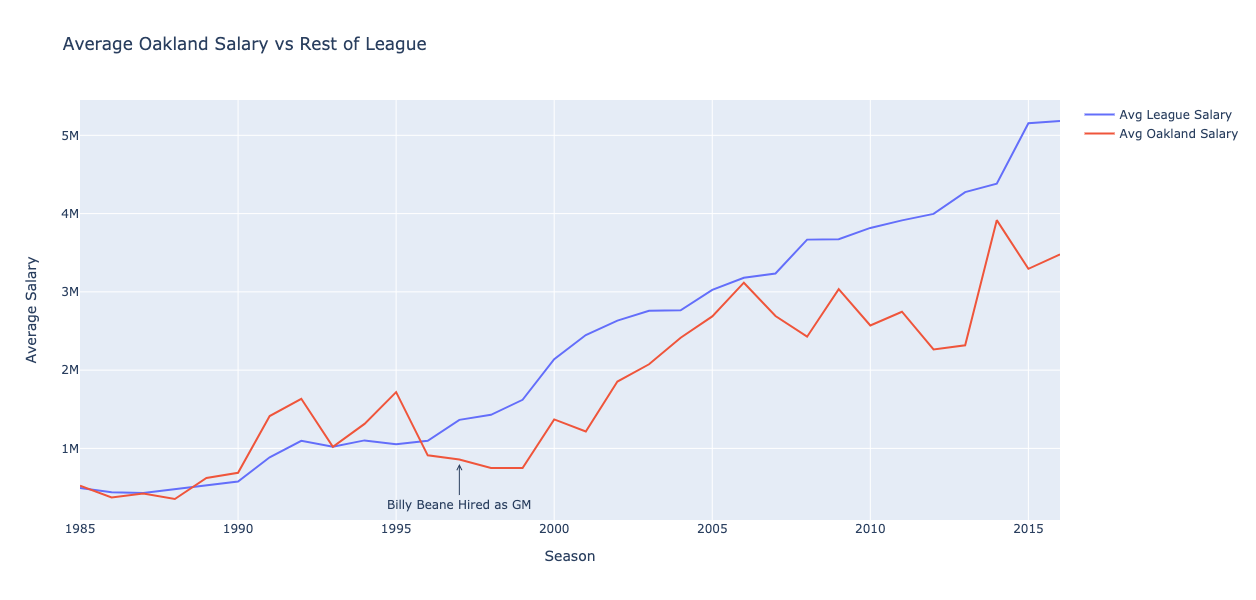

In [126]:
avg_league_salary = go.Scatter(x=salary_comp.index, y=salary_comp['Avg_League_Salary'],
                      name='Avg League Salary')

avg_oakland_salary = go.Scatter(x=salary_comp.index, y=salary_comp['Avg_Oakland_Salary'],
                      name='Avg Oakland Salary')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Salary vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Salary'))

fig = go.Figure(data=[avg_league_salary, avg_oakland_salary], layout=layout)

fig.add_annotation(
            x=1997,
            y=800000,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [93]:
# TODO - df and graph for on base plus slugging for oakland vs the rest of the league
obp = pd.concat([oak['On_Base_Percentage'], rest_of_league['On_Base_Percentage']], axis=1)
obp.columns = ['Avg_Oakland_OBP', 'Avg_League_OBP']
obp.head()

,Avg_Oakland_OBP,Avg_League_OBP
Season,,
1985,0.322829,0.275664
1986,0.311147,0.278476
1987,0.322331,0.271851
1988,0.328375,0.269008
1989,0.315476,0.271532


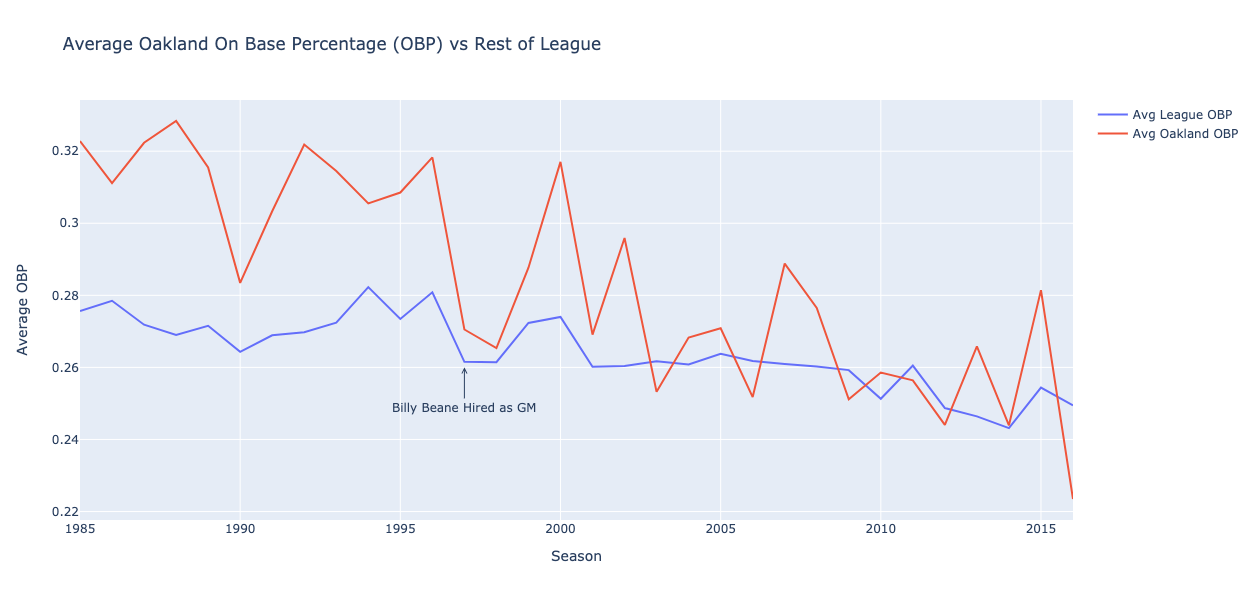

In [144]:
avg_league_obp = go.Scatter(x=obp.index, y=obp['Avg_League_OBP'],
                      name='Avg League OBP')

avg_oakland_obp = go.Scatter(x=obp.index, y=obp['Avg_Oakland_OBP'],
                      name='Avg Oakland OBP')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland On Base Percentage (OBP) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average OBP'))

fig = go.Figure(data=[avg_league_obp, avg_oakland_obp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.26,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [98]:
slg = pd.concat([oak['Slugging_Percentage'], rest_of_league['Slugging_Percentage']], axis=1)
slg.columns = ['Avg_Oakland_SLG', 'Avg_League_SLG']
slg.head()

,Avg_Oakland_SLG,Avg_League_SLG
Season,,
1985,0.407661,0.330050
1986,0.329521,0.330573
1987,0.403054,0.333195
1988,0.376966,0.312569
1989,0.374205,0.317884


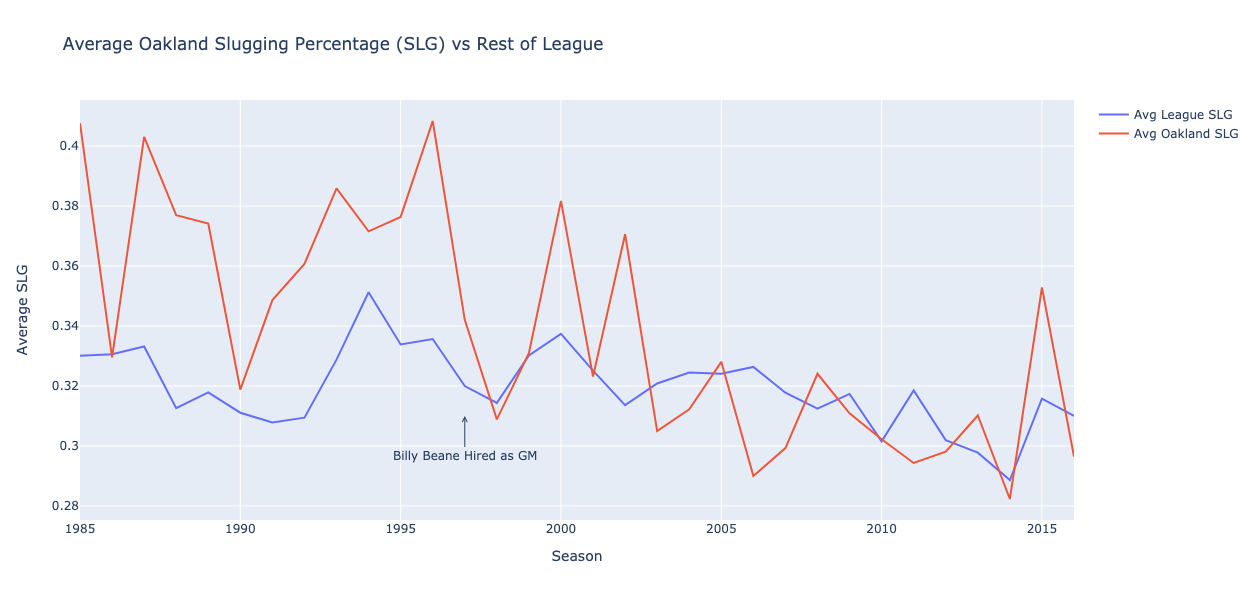

In [140]:
avg_league_slg = go.Scatter(x=slg.index, y=slg['Avg_League_SLG'],
                      name='Avg League SLG')

avg_oakland_slg = go.Scatter(x=slg.index, y=slg['Avg_Oakland_SLG'],
                      name='Avg Oakland SLG')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Slugging Percentage (SLG) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average SLG'))

fig = go.Figure(data=[avg_league_slg, avg_oakland_slg], layout=layout)

fig.add_annotation(
            x=1997,
            y=.31,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [89]:
# TODO - df and graph for on base plus slugging for oakland vs the rest of the league
on_base_plus_slug_comp = pd.concat([oak['On_Base_Plus_Slugging'], rest_of_league['On_Base_Plus_Slugging']], axis=1)
on_base_plus_slug_comp.columns = ['Avg_Oakland_OPS', 'Avg_League_OPS']
on_base_plus_slug_comp.head()

,Avg_Oakland_OPS,Avg_League_OPS
Season,,
1985,0.730490,0.605714
1986,0.640668,0.609049
1987,0.725385,0.605046
1988,0.705340,0.581577
1989,0.689681,0.589416


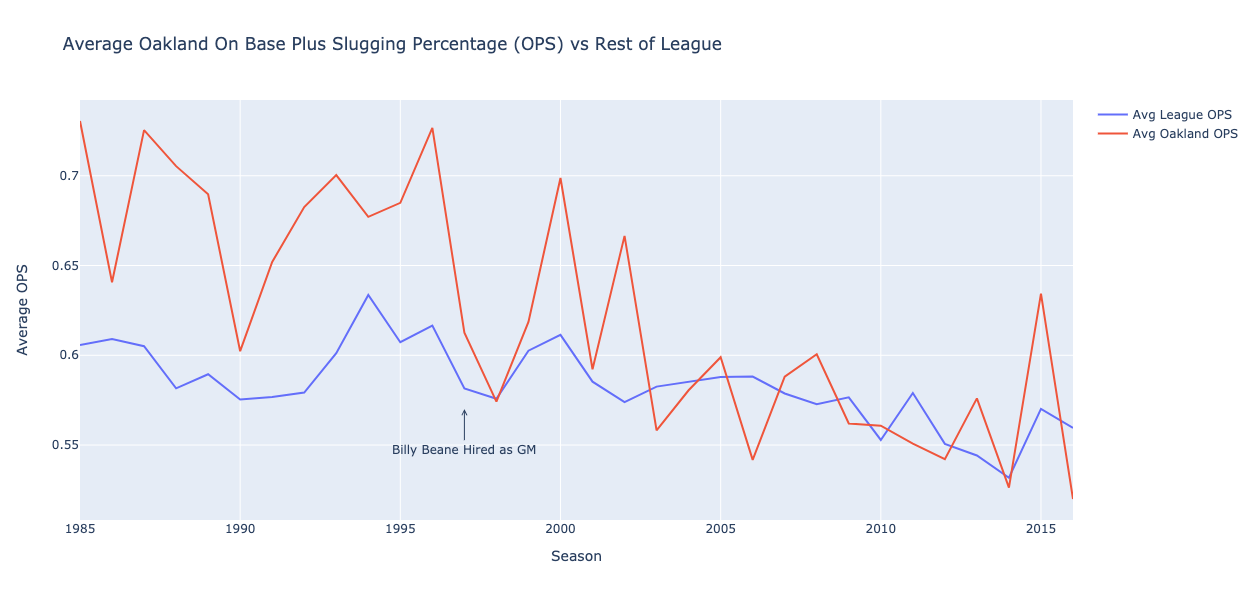

In [145]:
avg_league_ops = go.Scatter(x=on_base_plus_slug_comp.index, y=on_base_plus_slug_comp['Avg_League_OPS'],
                      name='Avg League OPS')

avg_oakland_ops = go.Scatter(x=on_base_plus_slug_comp.index, y=on_base_plus_slug_comp['Avg_Oakland_OPS'],
                      name='Avg Oakland OPS')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland On Base Plus Slugging Percentage (OPS) vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average OPS'))

fig = go.Figure(data=[avg_league_ops, avg_oakland_ops], layout=layout)

fig.add_annotation(
            x=1997,
            y=.57,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [101]:
walk_percentage_comp = pd.concat([oak['Walk_Percentage'], rest_of_league['Walk_Percentage']], axis=1)
walk_percentage_comp.columns = ['Avg_Oakland_WP', 'Avg_League_WP']
walk_percentage_comp.head()

,Avg_Oakland_WP,Avg_League_WP
Season,,
1985,0.078249,0.075542
1986,0.114227,0.078194
1987,0.098517,0.073581
1988,0.097671,0.072044
1989,0.091202,0.072434


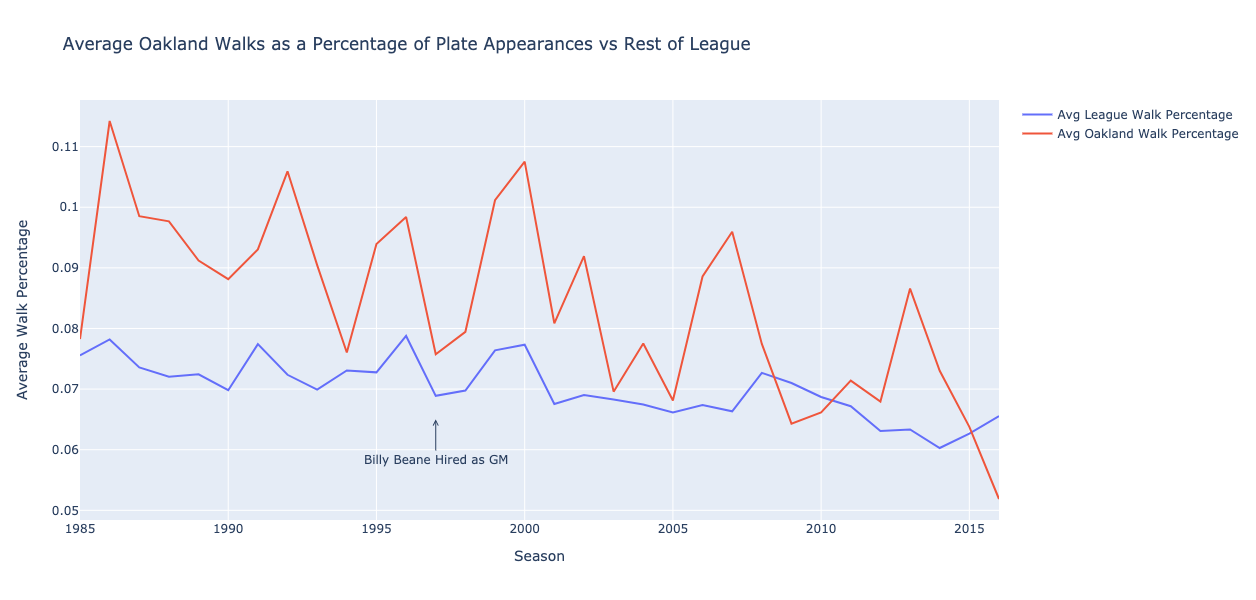

In [149]:
avg_league_wp = go.Scatter(x=walk_percentage_comp.index, y=walk_percentage_comp['Avg_League_WP'],
                      name='Avg League Walk Percentage')

avg_oakland_wp = go.Scatter(x=walk_percentage_comp.index, y=walk_percentage_comp['Avg_Oakland_WP'],
                      name='Avg Oakland Walk Percentage')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Walks as a Percentage of Plate Appearances vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Walk Percentage'))

fig = go.Figure(data=[avg_league_wp, avg_oakland_wp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.065,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [104]:
strikeout_percentage_comp = pd.concat([oak['Strikeout_Percentage'], rest_of_league['Strikeout_Percentage']], axis=1)
strikeout_percentage_comp.columns = ['Avg_Oakland_SP', 'Avg_League_SP']
strikeout_percentage_comp.head()

,Avg_Oakland_SP,Avg_League_SP
Season,,
1985,0.152288,0.213050
1986,0.174635,0.237796
1987,0.206076,0.240254
1988,0.174308,0.224067
1989,0.166782,0.230875


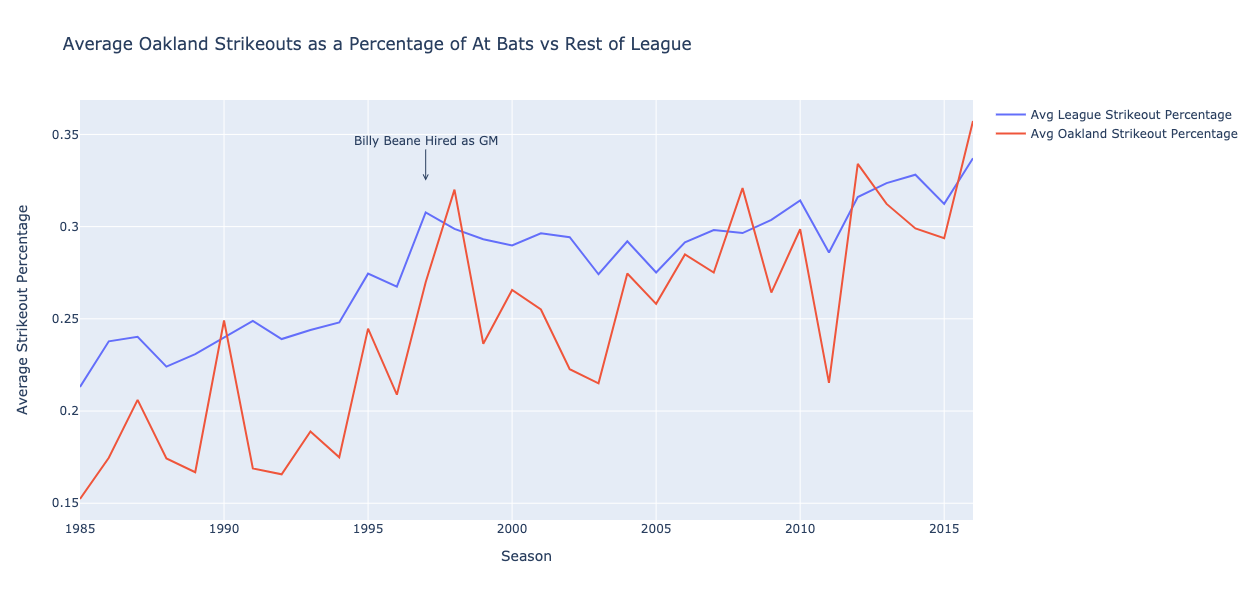

In [156]:
avg_league_sp = go.Scatter(x=strikeout_percentage_comp.index, y=strikeout_percentage_comp['Avg_League_SP'],
                      name='Avg League Strikeout Percentage')

avg_oakland_sp = go.Scatter(x=strikeout_percentage_comp.index, y=strikeout_percentage_comp['Avg_Oakland_SP'],
                      name='Avg Oakland Strikeout Percentage')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Strikeouts as a Percentage of At Bats vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Strikeout Percentage'))

fig = go.Figure(data=[avg_league_sp, avg_oakland_sp], layout=layout)

fig.add_annotation(
            x=1997,
            y=.325,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=-40
)

fig.show()

In [107]:
walks_to_strikeouts = pd.concat([oak['Walks_To_Strikeouts'], rest_of_league['Walks_To_Strikeouts']], axis=1)
walks_to_strikeouts.columns = ['Avg_Oakland_WTS', 'Avg_League_WTS']
walks_to_strikeouts.head()

,Avg_Oakland_WTS,Avg_League_WTS
Season,,
1985,0.597596,0.622362
1986,0.494879,0.540967
1987,0.608505,0.525663
1988,0.665753,0.535158
1989,0.626295,0.543289


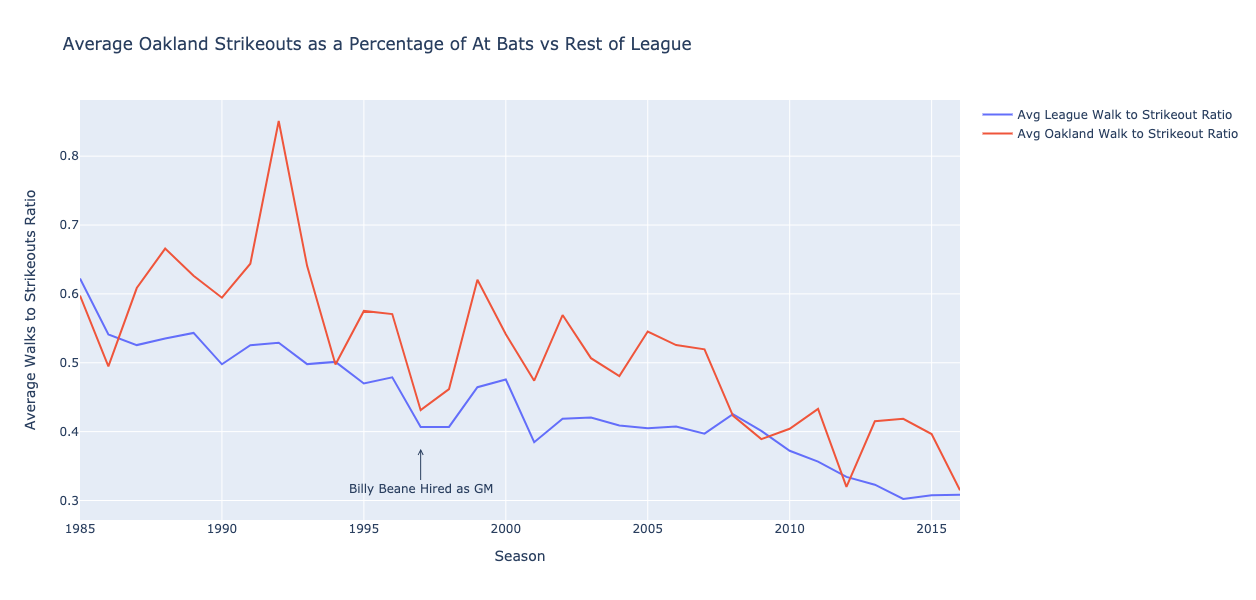

In [157]:
avg_league_wts = go.Scatter(x=walks_to_strikeouts.index, y=walks_to_strikeouts['Avg_League_WTS'],
                      name='Avg League Walk to Strikeout Ratio')

avg_oakland_wts = go.Scatter(x=walks_to_strikeouts.index, y=walks_to_strikeouts['Avg_Oakland_WTS'],
                      name='Avg Oakland Walk to Strikeout Ratio')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Strikeouts as a Percentage of At Bats vs Rest of League',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Walks to Strikeouts Ratio'))

fig = go.Figure(data=[avg_league_wts, avg_oakland_wts], layout=layout)

fig.add_annotation(
            x=1997,
            y=.375,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [111]:
player_value_comp = pd.concat([oak['Player_Value'], rest_of_league['Player_Value']], axis=1)
player_value_comp.columns = ['Avg_Oakland_PV', 'Avg_League_PV']
player_value_comp.head()

,Avg_Oakland_PV,Avg_League_PV
Season,,
1985,378601.491409,309328.034317
1986,250644.536086,281826.684773
1987,316474.388037,280917.735269
1988,252387.929795,296706.514609
1989,473696.556241,326561.255012


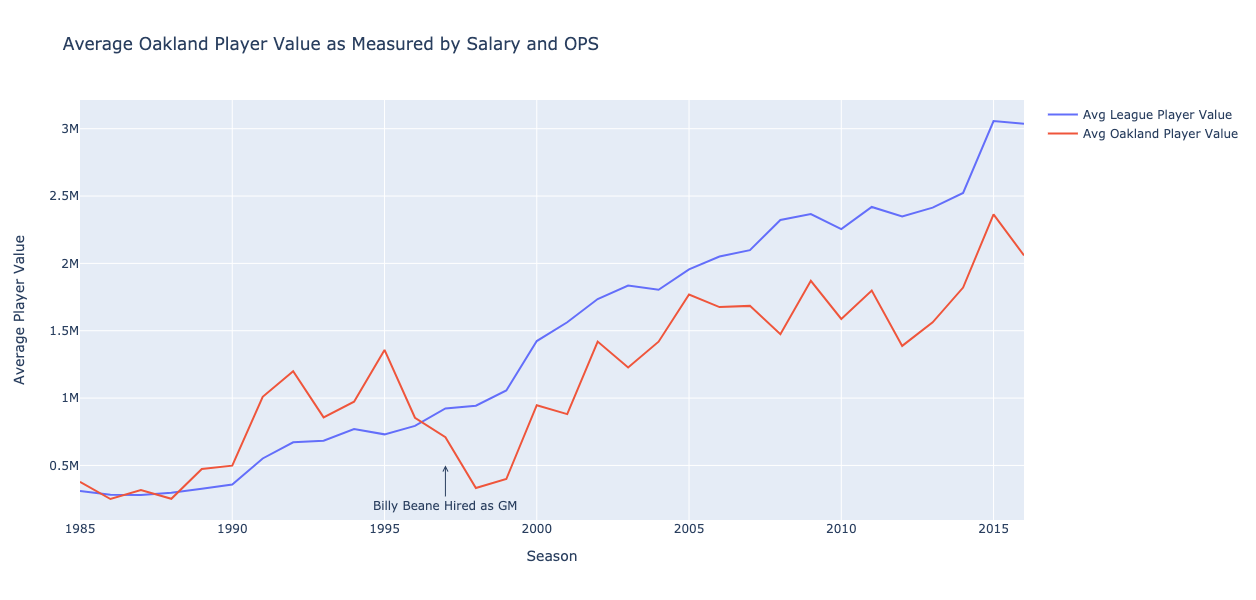

In [160]:
avg_league_pv = go.Scatter(x=player_value_comp.index, y=player_value_comp['Avg_League_PV'],
                      name='Avg League Player Value')

avg_oakland_pv = go.Scatter(x=player_value_comp.index, y=player_value_comp['Avg_Oakland_PV'],
                      name='Avg Oakland Player Value')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Player Value as Measured by Salary and OPS',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Player Value'))

fig = go.Figure(data=[avg_league_pv, avg_oakland_pv], layout=layout)

fig.add_annotation(
            x=1997,
            y=500000,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [169]:
years_comp = pd.concat([oak['Years_In_League'], rest_of_league['Years_In_League']], axis=1)
years_comp.columns = ['Avg_Oakland_YC', 'Avg_League_YC']
years_comp = years_comp[years_comp.index >= 1990]
years_comp.head()

,Avg_Oakland_YC,Avg_League_YC
Season,,
1990,2.916667,2.835987
1991,4.933333,3.391555
1992,4.875000,3.678883
1993,3.500000,3.409289
1994,5.235294,3.769475


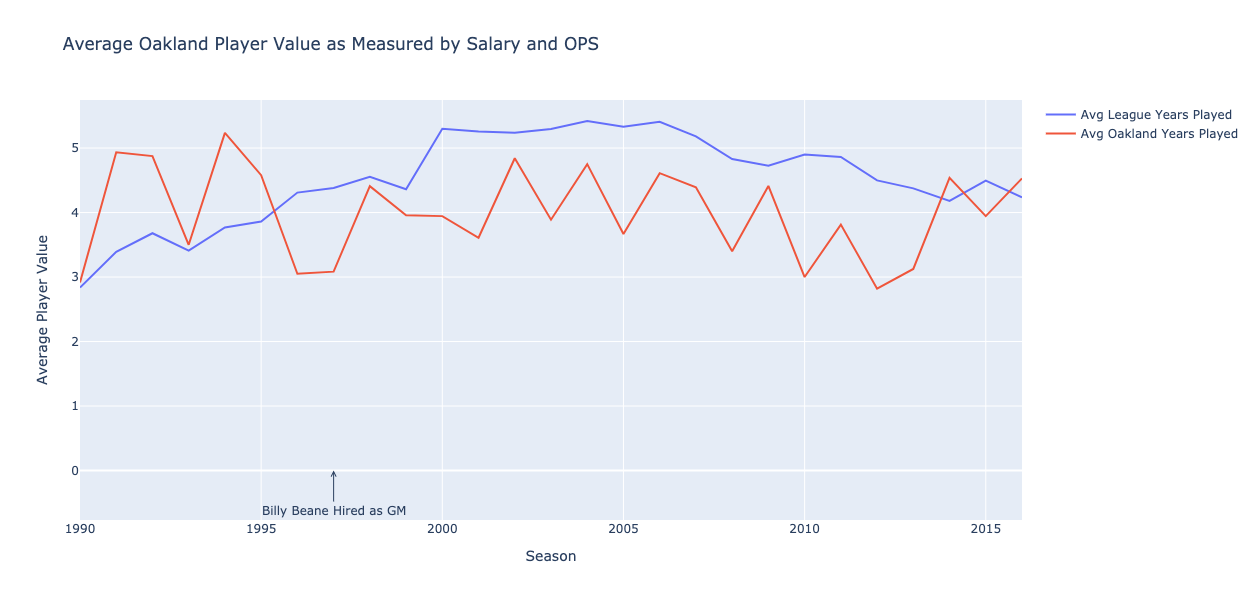

In [170]:
avg_league_yc = go.Scatter(x=years_comp.index, y=years_comp['Avg_League_YC'],
                      name='Avg League Years Played')

avg_oakland_yc = go.Scatter(x=years_comp.index, y=years_comp['Avg_Oakland_YC'],
                      name='Avg Oakland Years Played')

layout = go.Layout(height=600, width=1000, 
                 title= 'Average Oakland Player Value as Measured by Salary and OPS',
                 xaxis=dict(title='Season'), yaxis=dict(title='Average Player Value'))
                                                            
fig = go.Figure(data=[avg_league_yc, avg_oakland_yc], layout=layout)

fig.add_annotation(
            x=1997,
            y=0,
            xref="x",
            yref="y",
            text="Billy Beane Hired as GM",
            showarrow=True,
            arrowhead=5,
            ax=0,
            ay=40
)

fig.show()

In [33]:
# df['Inflation_Adj_Salary'] = (df['salary'] * df['Inflation_Adj']).astype(int)
# df.head()

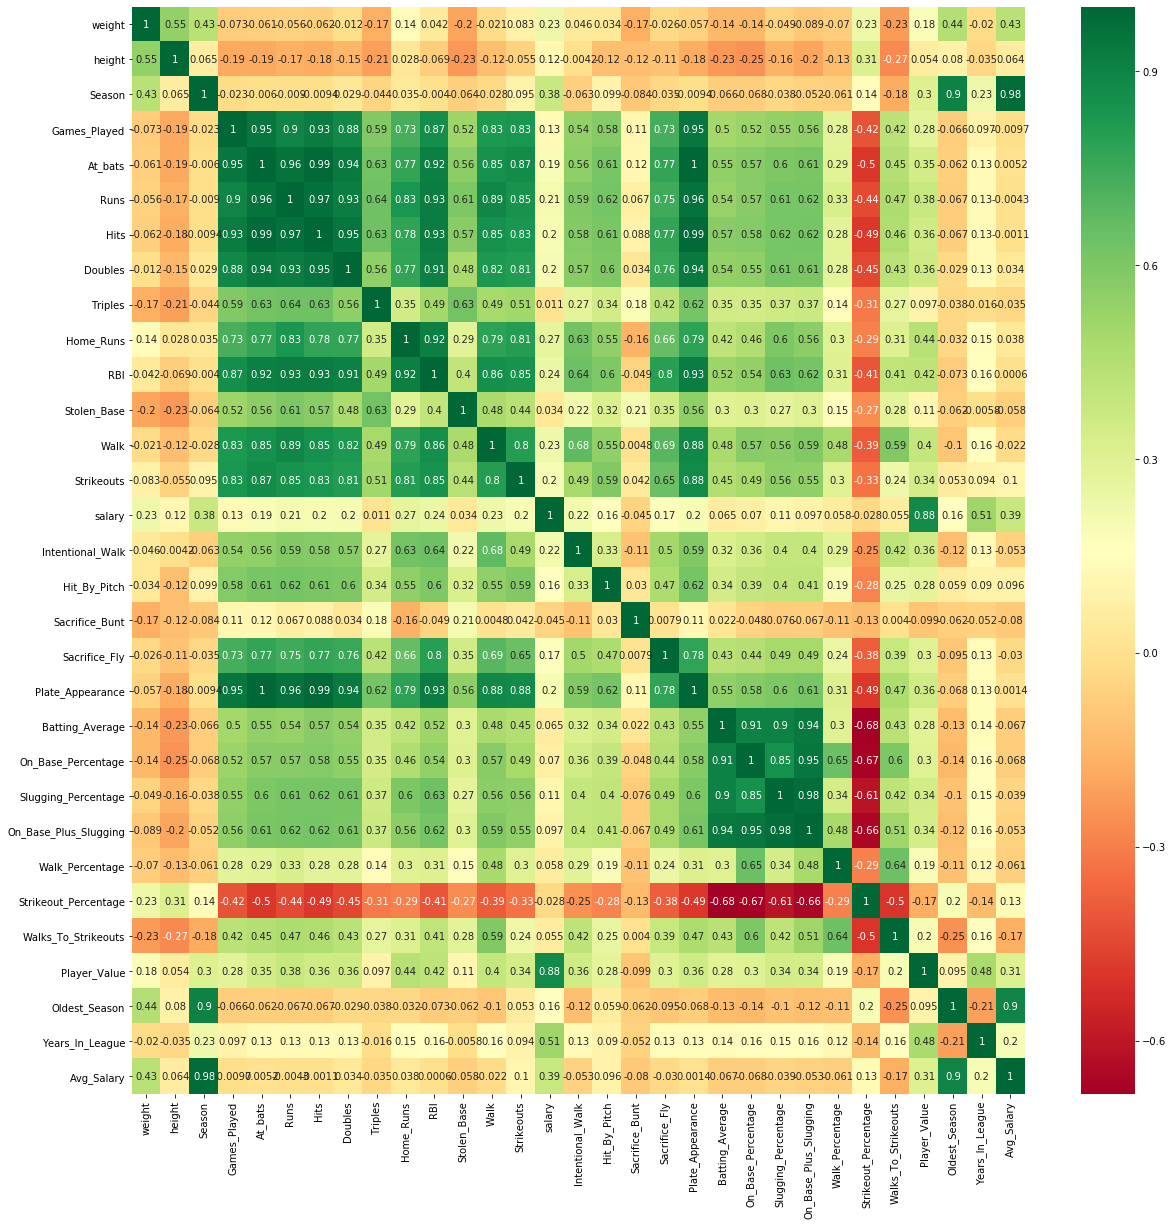

In [34]:
# get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

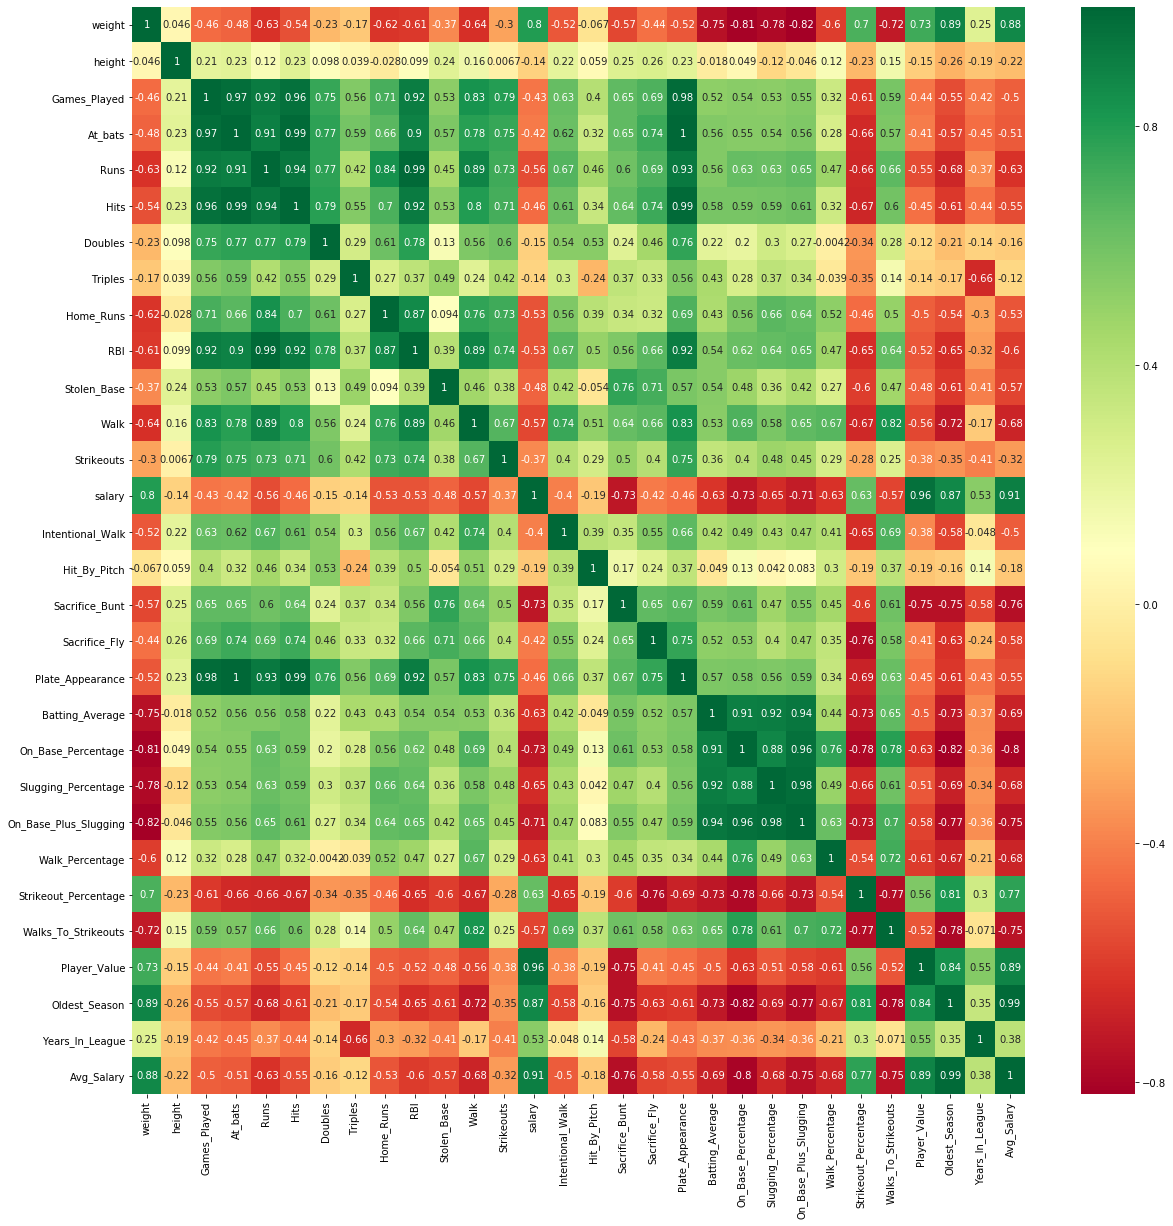

In [35]:
# get correlations of each features in dataset
corrmat = oak.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(oak[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [36]:
# mean absolute error
errors = df['Avg_Salary'] - df['salary']
mean_absolute_error = errors.abs().mean()
print(f"""If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of ${mean_absolute_error:,.0f}""")

If we just guessed a player's salary to be the average salary of a player
in that season it would be off by an average of $2,246,635


In [37]:
df.columns

Index(['playerID', 'Player Name', 'weight', 'height', 'bats', 'throws',
       'Season', 'League', 'teamID', 'Team', 'Franchise', 'Games_Played',
       'At_bats', 'Runs', 'Hits', 'Doubles', 'Triples', 'Home_Runs', 'RBI',
       'Stolen_Base', 'Walk', 'Strikeouts', 'salary', 'Intentional_Walk',
       'Hit_By_Pitch', 'Sacrifice_Bunt', 'Sacrifice_Fly', 'Plate_Appearance',
       'Batting_Average', 'On_Base_Percentage', 'Slugging_Percentage',
       'On_Base_Plus_Slugging', 'Walk_Percentage', 'Strikeout_Percentage',
       'Walks_To_Strikeouts', 'Player_Value', 'Oldest_Season',
       'Years_In_League', 'Avg_Salary'],
      dtype='object')

In [38]:
# features
features = [
 'Season',
 'Games_Played',
 'At_bats',
 'Runs',
 'Hits',
 'Doubles',
 'Home_Runs',
 'RBI',
 'Walk',
 'Strikeouts',
 'Intentional_Walk',
 'Plate_Appearance',
 'On_Base_Percentage',
 'Batting_Average',
 'Slugging_Percentage',
 'On_Base_Plus_Slugging',
 'Walk_Percentage',
 'Strikeout_Percentage',
 'Walks_To_Strikeouts',
 'Years_In_League']

# shuffle data
df = shuffle(df)
# drop target
y = df.pop('salary')
X = df[features]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((12492, 20), (4164, 20), (4165, 20), (12492,), (4164,), (4165,))

In [39]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs         Score
11  Plate_Appearance  1.078906e+06
2            At_bats  9.249677e+05
4               Hits  2.989846e+05
7                RBI  1.977755e+05
3               Runs  1.818827e+05
9         Strikeouts  1.733050e+05
8               Walk  1.615703e+05
1       Games_Played  1.406012e+05
6          Home_Runs  7.831769e+04
5            Doubles  6.550210e+04


/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


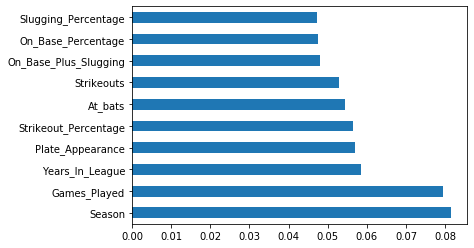

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show();

In [41]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    DecisionTreeRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 1720813.6681872748
R^2 0.2205940709302504


In [42]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    KNeighborsRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 1435292.010372149
R^2: 0.5128150103934168


In [43]:
pipeline = make_pipeline(
    StandardScaler(),
    ce.OneHotEncoder(use_cat_names=True),
    RandomForestRegressor())

# Fit on train
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

/Users/josephbell/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Mean Absolute Error: 1339247.4251020406
R^2: 0.5797323531636385


In [44]:
Season = 2016
Games_Played = 120
At_bats = 170
Runs = 25
Hits = 100
Doubles = 8
Home_Runs = 10
RBI = 70
Walk = 30
Strikeouts = 30
Intentional_Walk = 2
Plate_Appearance = 180
On_Base_Percentage = .400
Batting_Average = .350
Slugging_Percentage = .500
On_Base_Plus_Slugging = .900
Walk_Percentage = .10
Strikeout_Percentage = .30
Walks_To_Strikeouts = .20
Years_In_League = 6

X_test = [[
 Season,
 Games_Played,
 At_bats,
 Runs,
 Hits,
 Doubles,
 Home_Runs,
 RBI,
 Walk,
 Strikeouts,
 Intentional_Walk,
 Plate_Appearance,
 On_Base_Percentage,
 Batting_Average,
 Slugging_Percentage,
 On_Base_Plus_Slugging,
 Walk_Percentage,
 Strikeout_Percentage,
 Walks_To_Strikeouts,
 Years_In_League]]

y_pred = pipeline.predict(X_test)
print(f'Predicted salary of ${y_pred.astype(int)[0]:,.0f}')

Predicted salary of $10,295,714
